In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

import utilities

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [3]:
trn_txt, trn_lb = [], []
for x, lb in imdb['train']:
    trn_txt.append(x.numpy().decode('utf-8'))
    trn_lb.append(lb.numpy())
    
val_txt, val_lb = [], []
for x, lb in imdb['test']:
    val_txt.append(x.numpy().decode('utf-8'))
    val_lb.append(lb.numpy())
    
trn_lb = np.array(trn_lb)
val_lb = np.array(val_lb)

In [35]:
def fit_imdb(vocab_size=10000, embed_d=16, nn='ave', hidden_d=16, filnum=128, filwid=5,
             maxlen=None, epochs=10, batch=128):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(trn_txt)
    
    trn_seq = tokenizer.texts_to_sequences(trn_txt)
    val_seq = tokenizer.texts_to_sequences(val_txt)
    
    trn_seq = pad_sequences(trn_seq, padding='post', maxlen=maxlen, truncating='post')
    val_seq = pad_sequences(val_seq, padding='post', maxlen=maxlen, truncating='post')
    
    if nn == 'ave':
        layers = [keras.layers.GlobalAveragePooling1D()]
    elif nn == 'lstm':
        layers = [keras.layers.Bidirectional(keras.layers.LSTM(hidden_d))]
    elif nn == 'gru':
        layers = [keras.layers.Bidirectional(keras.layers.GRU(hidden_d))]
    elif nn == 'conv':
        layers = [
            keras.layers.Conv1D(filnum, filwid, activation='relu'),
            keras.layers.GlobalMaxPooling1D(),
        ]
    else:
        raise Exception('Invalid nn option: ' + str(nn))
        
    model = keras.models.Sequential(
        [keras.layers.Embedding(vocab_size, embed_d)]
        + layers
        + [keras.layers.Dense(1, activation='sigmoid')]
    )
    model.summary()
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    
    history = model.fit(
        trn_seq, trn_lb,
        epochs=epochs, batch_size=batch,
        validation_data = (val_seq, val_lb),
        callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3)],
    )
    utilities.plot_train_val_metrics(history, ['loss', 'accuracy'])
    
    return model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 1)           10000     
                                                                 
 global_average_pooling1d_12  (None, 1)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 10,002
Trainable params: 10,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6929 - val_accuracy: 0.5300
Epoch 2/300
196/196 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5792 - v

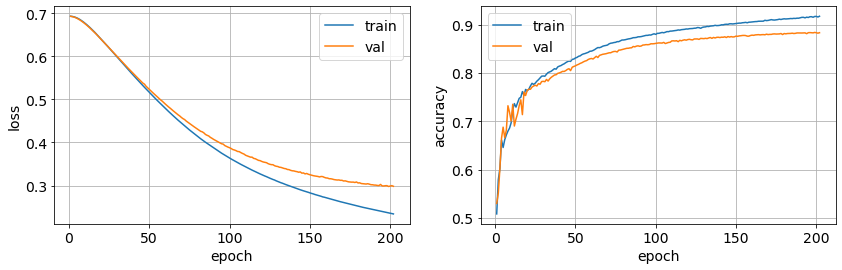

In [33]:
%%time
fit_imdb(embed_d=1, epochs=300)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 1)           10000     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               2304      
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,337
Trainable params: 12,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 36s 169ms/step - loss: 0.6672 - accuracy: 0.5855 - val_loss: 0.5997 - val_accuracy: 0.7467
Epoch 2/300
196/196 [==============================] - 33s 167ms/step - loss: 0.5359 - accuracy: 0.76

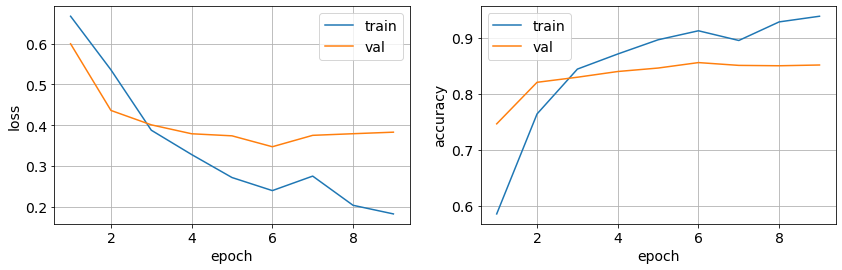

In [34]:
%%time
fit_imdb(embed_d=1, nn='lstm', epochs=300)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 164,257
Trainable params: 164,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 36s 173ms/step - loss: 0.5974 - accuracy: 0.6806 - val_loss: 0.4540 - val_accuracy: 0.8158
Epoch 2/300
196/196 [==============================] - 33s 169ms/step - loss: 0.3915 - accuracy: 0.

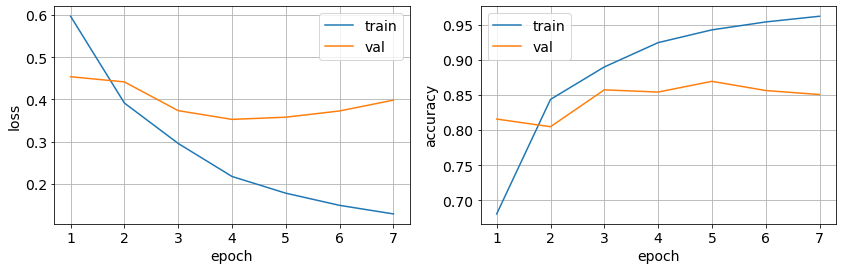

In [36]:
%%time
fit_imdb(embed_d=16, nn='lstm', epochs=300)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 16)          160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               3264      
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 163,297
Trainable params: 163,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 35s 170ms/step - loss: 0.6156 - accuracy: 0.6431 - val_loss: 0.4523 - val_accuracy: 0.8018
Epoch 2/300
196/196 [==============================] - 33s 168ms/step - loss: 0.3837 - accuracy: 0.

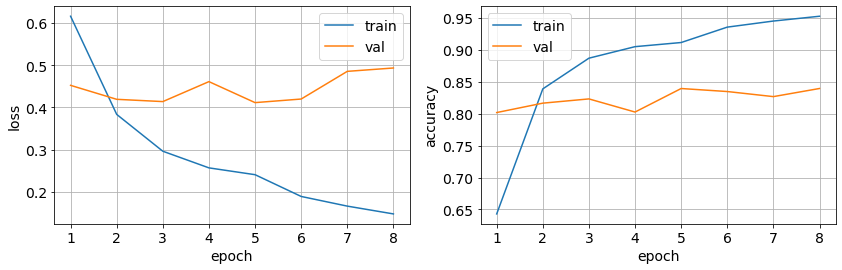

In [37]:
%%time
fit_imdb(embed_d=16, nn='gru', epochs=300)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 170,497
Trainable params: 170,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 5s 19ms/step - loss: 0.5844 - accuracy: 0.6812 - val_loss:

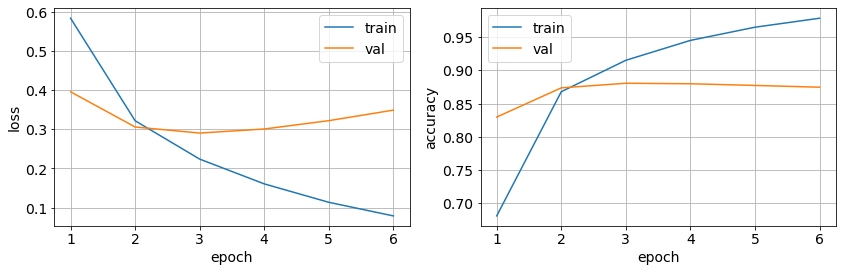

In [38]:
%%time
fit_imdb(embed_d=16, nn='conv', epochs=300)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 1)           10000     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         768       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 10,897
Trainable params: 10,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
196/196 [==============================] - 4s 17ms/step - loss: 0.6863 - accuracy: 0.5572 - val_loss: 0

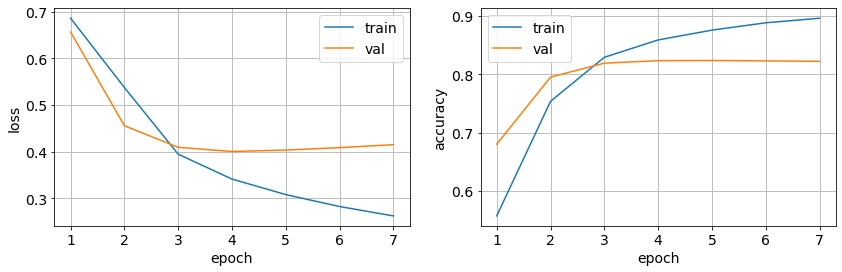

In [39]:
%%time
fit_imdb(embed_d=1, nn='conv', epochs=300)